In [135]:
import torch
from torch import nn

import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.0.1
0.15.2


CNN Explainer: https://poloclub.github.io/cnn-explainer/

In [136]:
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor(), target_transform=None)

print(len(train_data))
print(len(test_data))

60000
10000


In [137]:
class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [138]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(len(train_dataloader), len(test_dataloader))

1875 313


## Model

### Docs

[`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

[`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)





In [139]:
class CNN(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super(CNN, self).__init__()
        self.conv1_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape),
        )

    def forward(self, x):
        x = self.conv1_block_1(x)
        x = self.conv2_block_1(x)
        x = self.classifier(x)
        return x 



In [140]:
torch.manual_seed(42)

model = CNN(input_shape=1, hidden_units=10, output_shape=len(class_names))
model

CNN(
  (conv1_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2_block_1): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## Conv2d layer

In [141]:
torch.manual_seed(42)
images = torch.randn(32, 3, 64, 64) # (batch_size, channels, height, width)
test_image = images[0]
print(f"batch shape: {images.shape}")
print(f"image shape: {test_image.shape}")

batch shape: torch.Size([32, 3, 64, 64])
image shape: torch.Size([3, 64, 64])


In [142]:
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
conv_layer(images).shape

torch.Size([32, 10, 64, 64])

## Max pooling layer

In [143]:
max_pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
max_pool_layer(conv_layer(images)).shape

torch.Size([32, 10, 32, 32])

## Optimizer, loss function and metrics

In [144]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names))


In [145]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float):
    total_time = end - start
    print(f"Total Time: {total_time:.3f}s")
    return total_time


In [146]:

def train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)  # find average train_loss per batch for that particular epochs
    train_acc /= len(train_dataloader)

    print(f"Training Loss: {train_loss:.2f} | Training Accuracy: {train_acc:.2f}")


def test_step(model, test_dataloader, loss_fn, accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model(X_test)
            loss = loss_fn(test_pred, y_test)
            test_loss +=  loss
            test_acc += accuracy_fn(test_pred, y_test)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Test Loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}")


In [147]:
from tqdm.auto import tqdm

torch.manual_seed(42)

train_time_start = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn)
    test_step(model, test_dataloader, loss_fn, accuracy_fn)

train_time_end = timer()
total_train_time = print_train_time(train_time_start, train_time_end)

    


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Training Loss: 0.59 | Training Accuracy: 0.78


 20%|██        | 1/5 [00:41<02:44, 41.10s/it]

Test Loss: 0.41 | Test Accuracy: 0.85
Epoch: 1
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Training Loss: 0.37 | Training Accuracy: 0.87


 40%|████      | 2/5 [01:24<02:06, 42.23s/it]

Test Loss: 0.36 | Test Accuracy: 0.86
Epoch: 2
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Training Loss: 0.33 | Training Accuracy: 0.88


 60%|██████    | 3/5 [02:04<01:23, 41.56s/it]

Test Loss: 0.33 | Test Accuracy: 0.88
Epoch: 3
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Training Loss: 0.30 | Training Accuracy: 0.89


 80%|████████  | 4/5 [02:46<00:41, 41.41s/it]

Test Loss: 0.33 | Test Accuracy: 0.88
Epoch: 4
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Training Loss: 0.29 | Training Accuracy: 0.90


100%|██████████| 5/5 [03:26<00:00, 41.29s/it]

Test Loss: 0.31 | Test Accuracy: 0.89
Total Time: 206.492s


## Model Evaluation using Confusion Matrix

In [152]:
model.eval()

epoch = 0

y_preds = []

with torch.inference_mode():
    for X_test, y_test in test_dataloader:
        epoch += 1
        y_logit = model(X_test)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred)

y_preds = torch.cat(y_preds) # concatenate all the predictions into one tensor
print(y_preds.shape)

torch.Size([10000])


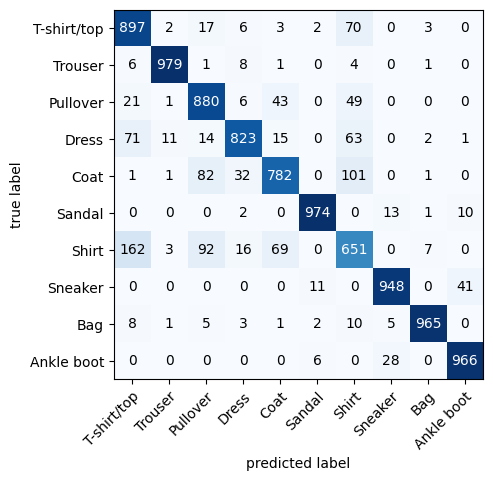

In [153]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

cm = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
conf_mat = cm(y_preds, test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat.numpy(), class_names=class_names)
plt.show()